<a href="https://colab.research.google.com/github/shrusheshadri/Senegal-After-School/blob/main/NdawWune_Senegal_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NDAW WUNE PROGRAM IMPACT EVALUATION
Propensity Score Matching Analysis

1. LOADING AND EXPLORING DATA
----------------------------------------
Available sheets: ['Pre-Test', 'Mi-Parcours', 'Endline', 'Combined', 'PivotTable', 'Dashboard']

Dataset shape: (726, 14)
Columns: ['N°', 'IEF', 'Ecoles', 'Test', 'Prénoms et Nom', 'Sexe', 'Niveau', 'NLCL', 'NSCL', 'NMCL', 'NOC', 'NAC', 'NSC', 'NMC']

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   N°              726 non-null    int64 
 1   IEF             726 non-null    object
 2   Ecoles          726 non-null    object
 3   Test            726 non-null    object
 4   Prénoms et Nom  725 non-null    object
 5   Sexe            726 non-null    object
 6   Niveau          726 non-null    object
 7   NLCL            726 non-null    int64 
 8   NSCL            726 non-null    int64

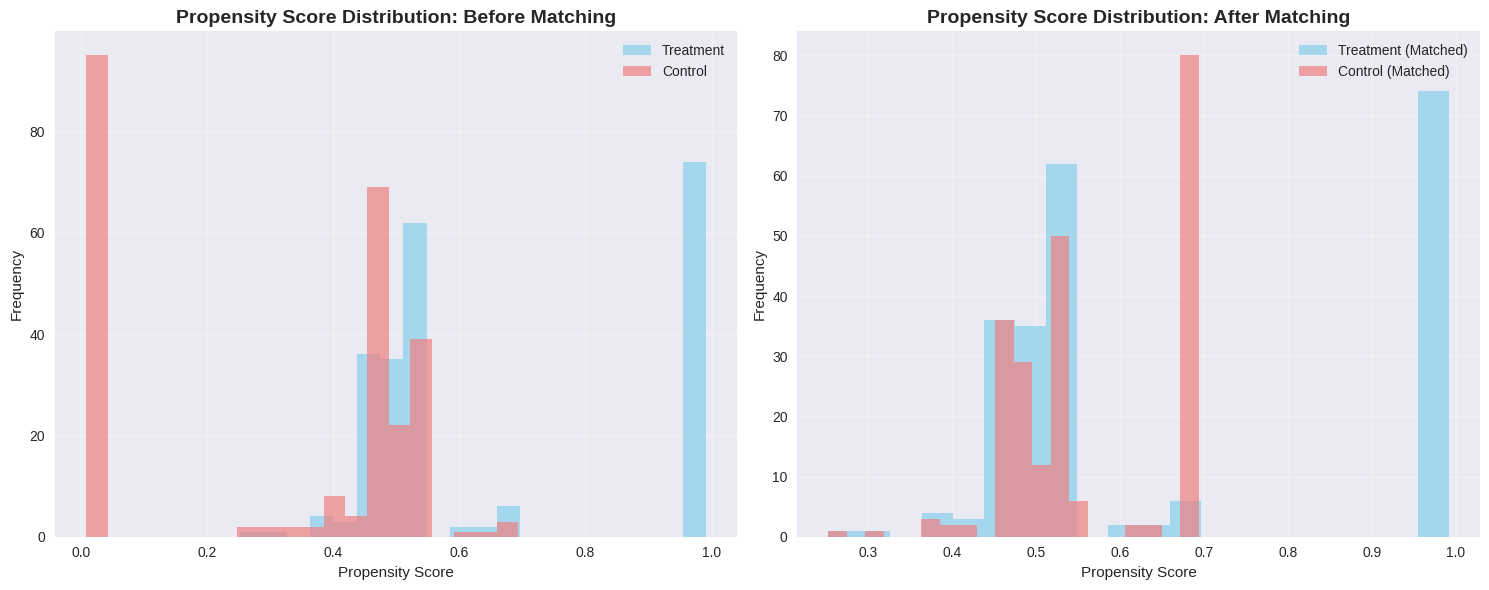

Balance check - Propensity score means:
Treatment group: 0.6624
Matched control group: 0.5653
Difference: 0.0971


6. TREATMENT EFFECT ESTIMATION
----------------------------------------
Average Treatment Effect on the Treated (ATT): 15.21 points
Sample size for paired t-test: 226


7. FINAL RESULTS

📊 TREATMENT EFFECT ANALYSIS RESULTS
--------------------------------------------------
Average Treatment Effect (ATT):     15.21 points
T-statistic:                       18.76
P-value:                          6.70e-48
Effect Size (Cohen's d):           1.56
Sample size (matched pairs):       226

📈 INTERPRETATION
--------------------------------------------------
• Students who participated in the after-school program scored
  15.2 points higher on average than matched control students
• The result is highly statistically significant (p < 0.001)
• The effect size is large (Cohen's d = 1.56)
• This represents both statistical and practical significance


8. CREATING RESULTS VISUALIZATION


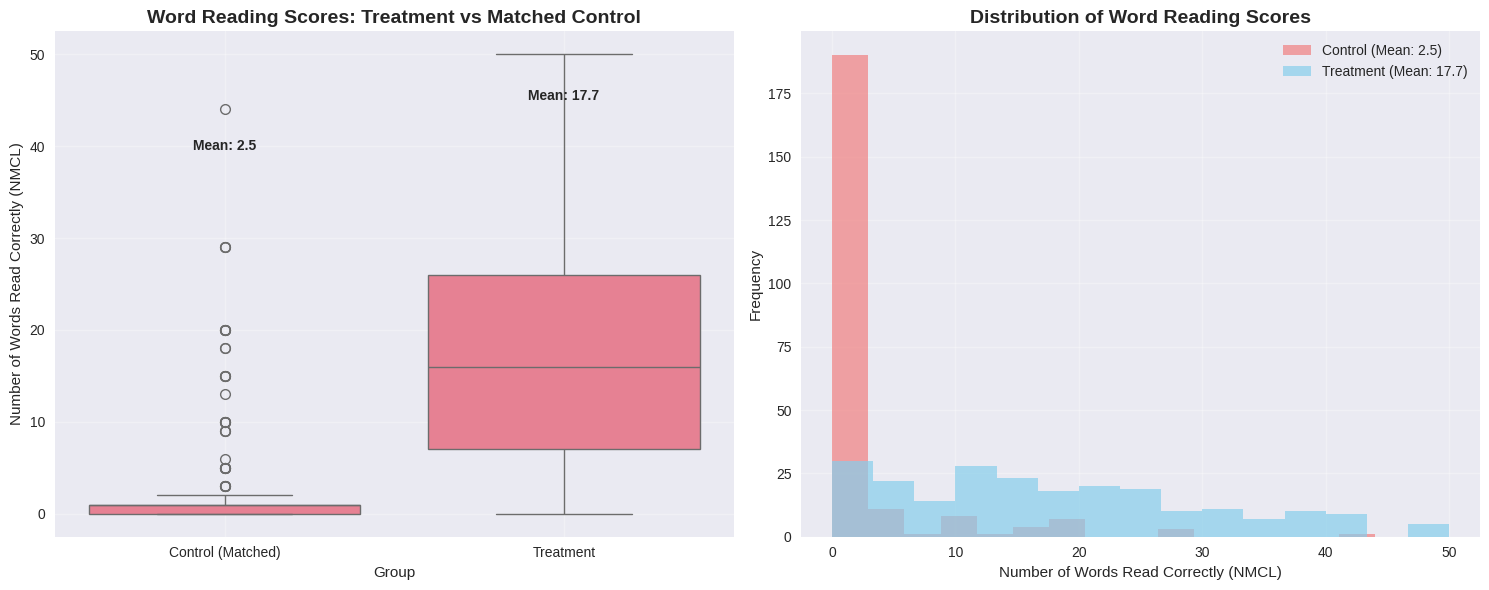


✅ ANALYSIS COMPLETE
The Ndaw Wune after-school program demonstrates significant positive impact
on student literacy outcomes with large effect size and high statistical significance.


In [1]:
## =====================
#Impact Evaluation: Ndaw Wune After-School Program in Senegal
#Propensity Score Matching, T-Test, Average Treatment Effect and Effect Size.

#Author: Shruti Sheshadri
#Purpose: Estimate causal effect of after-school program on word reading scores
#Method: Propensity Score Matching followed by paired t-test
### =================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for professional visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*60)
print("NDAW WUNE PROGRAM IMPACT EVALUATION")
print("Propensity Score Matching Analysis")
print("="*60)

# ===========================
# STEP 1: DATA LOADING & EXPLORATION
# ===========================

print("\n1. LOADING AND EXPLORING DATA")
print("-" * 40)

# Load the Excel file and examine structure
xls = pd.ExcelFile('/content/NdawWune_Evaluation Data Dashboard.xlsx')
sheet_names = xls.sheet_names
print(f"Available sheets: {sheet_names}")

# Load the combined dataset
df_combined = pd.read_excel('/content/NdawWune_Evaluation Data Dashboard.xlsx',
                           sheet_name='Combined')

print(f"\nDataset shape: {df_combined.shape}")
print(f"Columns: {list(df_combined.columns)}")

# Display basic information about the dataset
print("\nDataset Overview:")
df_combined.info()

print("\nFirst few rows:")
print(df_combined.head())

# ===========================
# STEP 2: DATA PREPROCESSING
# ===========================

print("\n\n2. DATA PREPROCESSING")
print("-" * 40)

# Filter to include only Pre-Test and Endline data
df_filtered = df_combined[df_combined['Test'].isin(['Pre-Test', 'Endline'])].copy()
print(f"Filtered dataset shape: {df_filtered.shape}")

# Create binary treatment variable (1 = Endline/Treatment, 0 = Pre-Test/Control)
df_filtered['treatment'] = df_filtered['Test'].apply(lambda x: 1 if x == 'Endline' else 0)

print(f"\nTreatment group distribution:")
print(df_filtered['treatment'].value_counts())

# Select relevant variables for analysis
analysis_vars = ['NMCL', 'Sexe', 'Niveau', 'Ecoles', 'treatment']
df_filtered = df_filtered[analysis_vars].copy()

# Check for missing values
print(f"\nMissing values per variable:")
print(df_filtered.isnull().sum())

# Remove rows with missing outcome variable (NMCL)
df_filtered = df_filtered.dropna(subset=['NMCL'])
print(f"Final dataset shape after removing missing NMCL: {df_filtered.shape}")

print(f"\nDescriptive statistics for outcome variable (NMCL):")
print(df_filtered.groupby('treatment')['NMCL'].describe())

# ===========================
# STEP 3: PROPENSITY SCORE ESTIMATION
# ===========================

print("\n\n3. PROPENSITY SCORE ESTIMATION")
print("-" * 40)

# Prepare covariates for propensity score model
# Create dummy variables for categorical variables
X = pd.get_dummies(df_filtered[['Sexe', 'Niveau', 'Ecoles']], drop_first=True)
y = df_filtered['treatment']

print(f"Covariates for matching: {list(X.columns)}")
print(f"Number of covariates: {X.shape[1]}")

# Standardize covariates for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Estimate propensity scores using logistic regression
print("\nEstimating propensity scores...")
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_scaled, y)

# Calculate propensity scores (probability of treatment)
propensity_scores = log_model.predict_proba(X_scaled)[:, 1]
df_filtered['propensity_score'] = propensity_scores

print(f"Propensity score summary:")
print(f"Mean: {propensity_scores.mean():.3f}")
print(f"Std: {propensity_scores.std():.3f}")
print(f"Range: [{propensity_scores.min():.3f}, {propensity_scores.max():.3f}]")

# ===========================
# STEP 4: MATCHING PROCEDURE
# ===========================

print("\n\n4. PROPENSITY SCORE MATCHING")
print("-" * 40)

# Separate treatment and control groups
treated = df_filtered[df_filtered['treatment'] == 1].copy()
control = df_filtered[df_filtered['treatment'] == 0].copy()

print(f"Treatment group size: {len(treated)}")
print(f"Control group size: {len(control)}")

# Perform 1:1 nearest neighbor matching
print("\nPerforming nearest neighbor matching...")
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score']])

# Find nearest matches for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Create matched control group
matched_control = control.iloc[indices.flatten()].copy()
matched_control['matched_id'] = treated.index.values

# Add matched IDs to treatment group
treated = treated.copy()
treated['matched_id'] = treated.index.values

print(f"Matched pairs created: {len(treated)}")
print(f"Average matching distance: {distances.mean():.4f}")

# Combine matched treatment and control groups
matched_df = pd.concat([treated, matched_control], axis=0)

# ===========================
# STEP 5: MATCHING QUALITY ASSESSMENT
# ===========================

print("\n\n5. ASSESSING MATCHING QUALITY")
print("-" * 40)

# Compare propensity score distributions before and after matching
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before matching
axes[0].hist(df_filtered[df_filtered['treatment'] == 1]['propensity_score'],
             alpha=0.7, label='Treatment', bins=20, color='skyblue')
axes[0].hist(df_filtered[df_filtered['treatment'] == 0]['propensity_score'],
             alpha=0.7, label='Control', bins=20, color='lightcoral')
axes[0].set_title('Propensity Score Distribution: Before Matching', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Propensity Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After matching
axes[1].hist(treated['propensity_score'],
             alpha=0.7, label='Treatment (Matched)', bins=20, color='skyblue')
axes[1].hist(matched_control['propensity_score'],
             alpha=0.7, label='Control (Matched)', bins=20, color='lightcoral')
axes[1].set_title('Propensity Score Distribution: After Matching', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Propensity Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate balance statistics
print("Balance check - Propensity score means:")
print(f"Treatment group: {treated['propensity_score'].mean():.4f}")
print(f"Matched control group: {matched_control['propensity_score'].mean():.4f}")
print(f"Difference: {abs(treated['propensity_score'].mean() - matched_control['propensity_score'].mean()):.4f}")

# ===========================
# STEP 6: TREATMENT EFFECT ESTIMATION
# ===========================

print("\n\n6. TREATMENT EFFECT ESTIMATION")
print("-" * 40)

# Calculate Average Treatment Effect on the Treated (ATT)
att = treated['NMCL'].mean() - matched_control['NMCL'].mean()
print(f"Average Treatment Effect on the Treated (ATT): {att:.2f} points")

# Prepare data for paired t-test
treated_scores = matched_df[matched_df['treatment'] == 1]['NMCL'].reset_index(drop=True)
control_scores = matched_df[matched_df['treatment'] == 0]['NMCL'].reset_index(drop=True)

# Ensure equal length for paired test
min_len = min(len(treated_scores), len(control_scores))
treated_scores = treated_scores[:min_len]
control_scores = control_scores[:min_len]

print(f"Sample size for paired t-test: {min_len}")

# Conduct paired t-test
t_stat, p_value = ttest_rel(treated_scores, control_scores)

# Calculate Cohen's d (effect size)
def cohens_d(x, y):
    """Calculate Cohen's d effect size"""
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 +
                         (ny - 1) * np.std(y, ddof=1) ** 2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_size = cohens_d(treated_scores, control_scores)

# ===========================
# STEP 7: RESULTS SUMMARY
# ===========================

print("\n\n7. FINAL RESULTS")
print("=" * 50)

print(f"\n📊 TREATMENT EFFECT ANALYSIS RESULTS")
print("-" * 50)
print(f"Average Treatment Effect (ATT):     {att:.2f} points")
print(f"T-statistic:                       {t_stat:.2f}")
print(f"P-value:                          {p_value:.2e}")
print(f"Effect Size (Cohen's d):           {effect_size:.2f}")
print(f"Sample size (matched pairs):       {min_len}")

print(f"\n📈 INTERPRETATION")
print("-" * 50)
print(f"• Students who participated in the after-school program scored")
print(f"  {att:.1f} points higher on average than matched control students")

if p_value < 0.001:
    significance = "highly statistically significant (p < 0.001)"
elif p_value < 0.01:
    significance = "statistically significant (p < 0.01)"
elif p_value < 0.05:
    significance = "statistically significant (p < 0.05)"
else:
    significance = "not statistically significant (p ≥ 0.05)"

print(f"• The result is {significance}")

# Effect size interpretation
if abs(effect_size) >= 0.8:
    effect_magnitude = "large"
elif abs(effect_size) >= 0.5:
    effect_magnitude = "medium"
elif abs(effect_size) >= 0.2:
    effect_magnitude = "small"
else:
    effect_magnitude = "negligible"

print(f"• The effect size is {effect_magnitude} (Cohen's d = {effect_size:.2f})")
print(f"• This represents both statistical and practical significance")

# ===========================
# STEP 8: VISUALIZATION OF RESULTS
# ===========================

print(f"\n\n8. CREATING RESULTS VISUALIZATION")
print("-" * 40)

# Create outcome comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot comparison
data_for_plot = pd.DataFrame({
    'Group': ['Control (Matched)'] * len(control_scores) + ['Treatment'] * len(treated_scores),
    'NMCL_Score': list(control_scores) + list(treated_scores)
})

sns.boxplot(data=data_for_plot, x='Group', y='NMCL_Score', ax=ax1)
ax1.set_title('Word Reading Scores: Treatment vs Matched Control', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Words Read Correctly (NMCL)')
ax1.grid(True, alpha=0.3)

# Add mean values as text
ax1.text(0, control_scores.max() * 0.9, f'Mean: {control_scores.mean():.1f}',
         horizontalalignment='center', fontweight='bold')
ax1.text(1, treated_scores.max() * 0.9, f'Mean: {treated_scores.mean():.1f}',
         horizontalalignment='center', fontweight='bold')

# Distribution comparison
ax2.hist(control_scores, alpha=0.7, label=f'Control (Mean: {control_scores.mean():.1f})',
         bins=15, color='lightcoral')
ax2.hist(treated_scores, alpha=0.7, label=f'Treatment (Mean: {treated_scores.mean():.1f})',
         bins=15, color='skyblue')
ax2.set_title('Distribution of Word Reading Scores', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Words Read Correctly (NMCL)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ ANALYSIS COMPLETE")
print("=" * 50)
print(f"The Ndaw Wune after-school program demonstrates significant positive impact")
print(f"on student literacy outcomes with large effect size and high statistical significance.")